[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/blob/main/07_20_23_day9_causal_modeling/code/diy_notebooks/exercise2.ipynb)


# Causal structure discovery: chain structure
Authors: Iman Wahle and Frederick Eberhardt

In this notebook, we will generate synthetic data from another hand-constructed 
model and use the PC algorithm to infer the underlying model. In particular,
we will look at an example where all edges are not orientable from the data.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
from mpl_toolkits.axes_grid1 import make_axes_locatable # for making subplots with colorbars

In [2]:
# colab setup
!pip install -q corner gdown causal-learn
import gdown
gdown.download("https://drive.google.com/uc?export=view&id=1jxir2Cz-_IKtPuBH0ZonRR4ZN0uwCDnf",
               "estimate_parameters.py", quiet=True)

'estimate_parameters.py'

## Generate data

We would like to generate data with the following causal structure: 

![exercise2_model.png](https://drive.google.com/uc?export=view&id=1uB-AUZ0yMlBK8nm79u_Wk7z7Zhi67cmM)

To do this, write a function `generate_data` that takes `n_samples` as an
argument. The data for variables $A$, $B$, and $C$, should be generated as follows:

- $A = \varepsilon_A$, where $\varepsilon_A \sim \mathcal{N}(0,1)$ 
- $B = aA + \varepsilon_B$, where $\varepsilon_B \sim \mathcal{N}(0,1)$ 
- $C = bB + \varepsilon_C$, where $\varepsilon_C \sim \mathcal{N}(0,1)$ 

$a$ and $b$ are constants you can set to whatever you like.

Once the samples have been generated, z-score the data so that each variable
has a mean of 0 and standard deviation of 1. 

The function should return:

  - `data`: an `n_samples` x 3 numpy array where each column corresponds to
    z-scored samples of $A$, $B$, and $C$.
  - `var_names` : a list of variable names 

Finally, use your function to generate 5000 samples from this model.

In [3]:
def generate_data(n_samples=5000):
    a, b = 1, 2

    A = np.random.normal(0, 1, size=n_samples)
    B = a*A + np.random.normal(0, 1, size=n_samples)
    C = b*B + np.random.normal(0, 1, size=n_samples)

    return np.vstack([A, B, C]).T, ['A', 'B', 'C']

data, var_names = generate_data()

## Initial data exploration

Before we begin the analysis, it is important to make sure the data matches
our expectations:

1. Print out the shape of the data and the names of the variables included
2. Construct a [corner plot](https://corner.readthedocs.io/en/latest/pages/quickstart/)
   of the variable distributions
3. Plot the correlation matrix over the three variables
4. Plot the inverse of the correlation matrix (aka the "precision matrix")

In [4]:
# inspect data shape and variable labels

print(data.shape)
print(var_names)

(5000, 3)
['A', 'B', 'C']


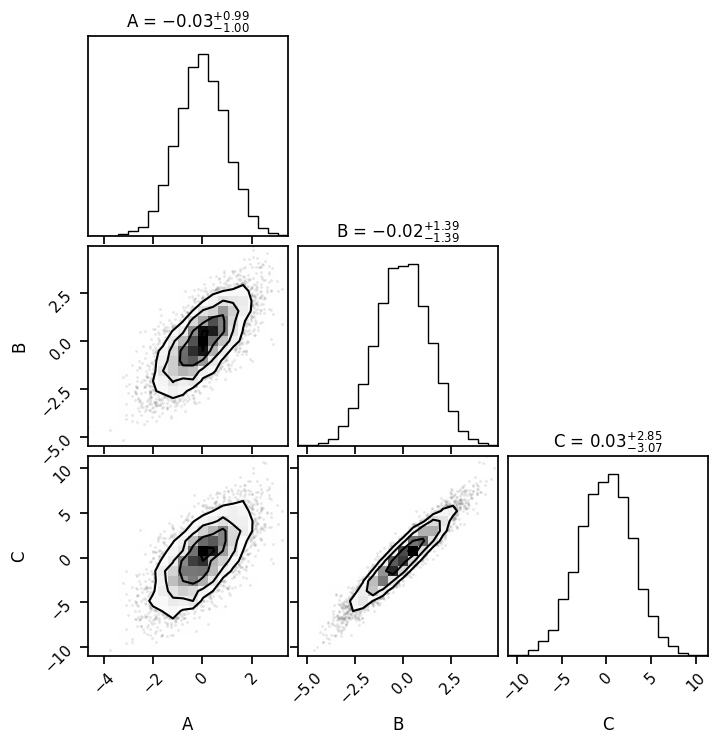

In [5]:
# make a corner plot of the three variables
from corner import corner

_ = corner(data, labels=var_names, show_titles=True)

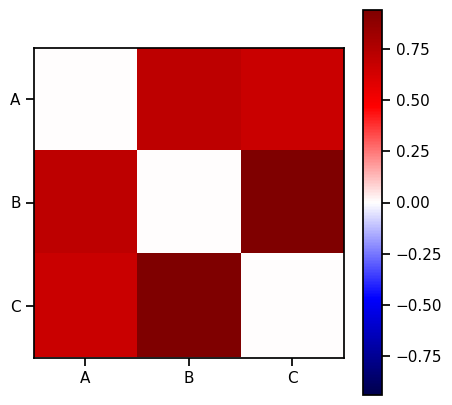

In [6]:
# plot the correlation matrix between the four variables (make sure to include 
# variable name labels!). Set the diagonal terms to 0 so that we can focus 
# on the relationships between variables.

corr = np.corrcoef(data.T)
np.fill_diagonal(corr, 0)
bound = np.max(np.abs(corr))

fig = plt.figure(figsize=(5,5))
plt.imshow(corr, cmap='seismic', vmin=-bound, vmax=bound, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Which entries do we expect to be zero/nonzero in the correlation matrix? 
Confirm that is the case in the plot above.

> Answer here

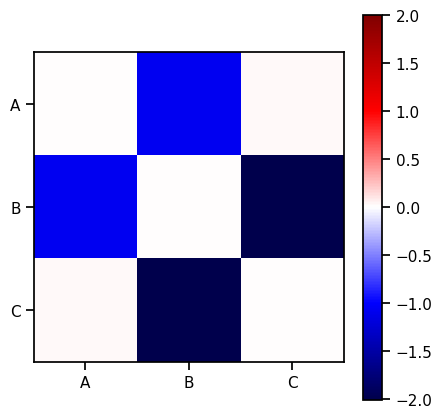

In [7]:
# plot the precision matrix between the three variables (make sure to include 
# variable name labels!). Set the diagonal terms to 0 so that we can focus 
# on the relationships between variables. 

precision = np.linalg.inv(np.cov(data.T))
np.fill_diagonal(precision, 0)
bound = np.nanmax(np.abs(precision))

fig = plt.figure(figsize=(5,5))
plt.imshow(precision, cmap='seismic', vmin=-bound, vmax=bound, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Which entries do we expect to be zero/nonzero in the precision matrix? 
Confirm that is the case in the plot above.

> Answer here

## Run the PC algorithm

Now that we have confirmed that our data looks as we expect, we are ready to 
use the PC algorithm to infer the causal graph that gave rise to this data.

Call the `pc` function on the dataset generated above with `alpha=0.05` and 
`indep_test='fisherz'` to start. Feel free to come back later and try different 
values for these arguments to see how they change the results.

In [8]:
# run PC algorithm

from causallearn.search.ConstraintBased.PC import pc

cg = pc(data, alpha=0.05, indep_test='fisherz')

  0%|          | 0/3 [00:00<?, ?it/s]

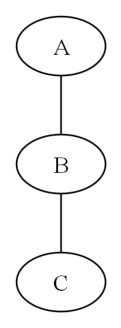

In [9]:
# plot the inferred graph using cg.draw_pydot_graph
fig = plt.figure(figsize=(4,4))
cg.draw_pydot_graph(labels=var_names)

Visualize the inferred PDAG in matrix form as well (this is stored at `cg.G.graph`).

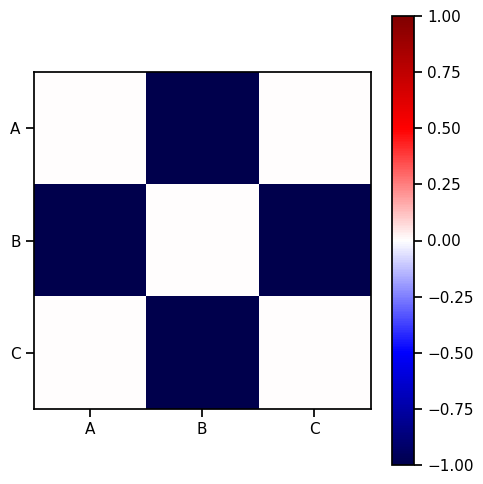

In [10]:
# visualize PDAG matrix `cg.G.Graph`

pdag_mat = cg.G.graph

fig = plt.figure(figsize=(5,5))
plt.imshow(pdag_mat, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Note that the edges in the recovered graph are not directed as they were in 
Exercise 1. Why is this the case?

> Answer here

Convert the matrix representation of the PDAG into an adjacency matrix and
visualize the result.

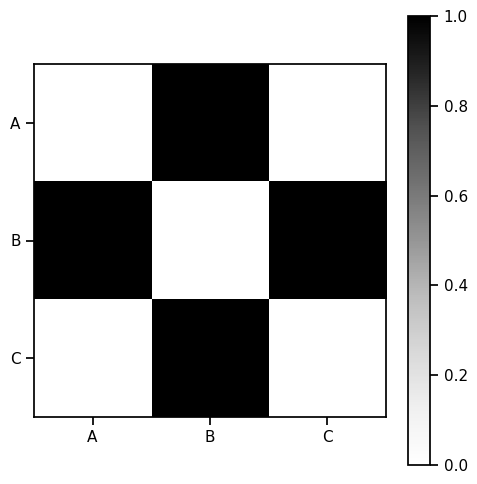

In [11]:
# convert PDAG matrix to adjacency matrix

fig = plt.figure(figsize=(5,5))
plt.imshow(np.abs(pdag_mat), cmap='Greys')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

## Estimate edge weights and covariance matrix from inferred graph

Since PC algorithm has only returned a partially directed acyclic 
graph (PDAG), we need to convert this to a fully directed acyclic graph
(DAG) in order to estimate edge weights across the graph (this can be any DAG
in the equivalence class described by the PDAG). The `causal-learn` package
has a utility function `pdag2dag` that takes in the graph object `cg.G` and 
returns a DAG.

The source code for `pdag2dag` is
[here](https://github.com/py-why/causal-learn/blob/main/causallearn/utils/PDAG2DAG.py)
if you are interested in looking at the implementation. 

In [12]:
# convert partial DAG to full DAG

from causallearn.utils.PDAG2DAG import pdag2dag

G_DAG = pdag2dag(cg.G)
dag_mat = G_DAG.graph

Plot the resulting adjacency matrix `dag_mat` to confirm all edges are now oriented. 

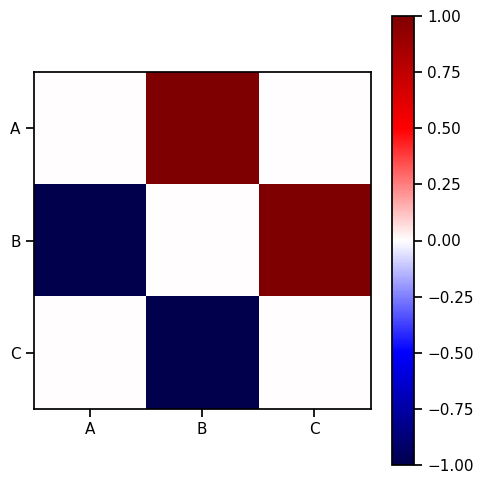

In [13]:
fig = plt.figure(figsize=(5,5))
plt.imshow(dag_mat, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Next, estimate the edge weights and residuals as you did in Exercise 1.

In [14]:
# learn edge weight estimates
from estimate_parameters import estimate_parameters

edge_weights, residuals = estimate_parameters(dag_mat, data)

Visualize both resulting matrices.

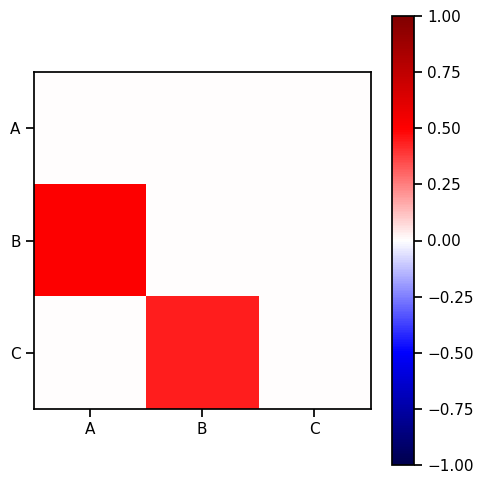

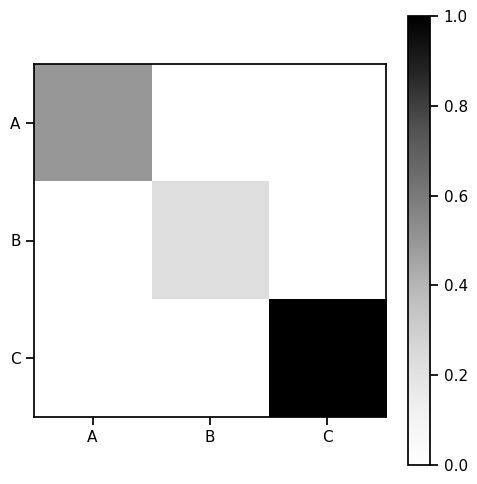

In [15]:
plt.figure(1, figsize=(5, 5))
plt.imshow(edge_weights, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

plt.figure(2, figsize=(5, 5))
plt.imshow(residuals, cmap='Greys', vmin=0, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

How do the estimated weights and residuals compare to the original data 
generation model? What may explain any differences?

> Answer here

Finally, estimate the correlation matrix from the inferred graph using the 
function you wrote in Exercise 1. Visualize the result and compare to the 
correlation matrix computed from the data.

In [16]:
# estimate correlation matrix

from estimate_parameters import get_correlation_matrix

est_corr = get_correlation_matrix(edge_weights, residuals)

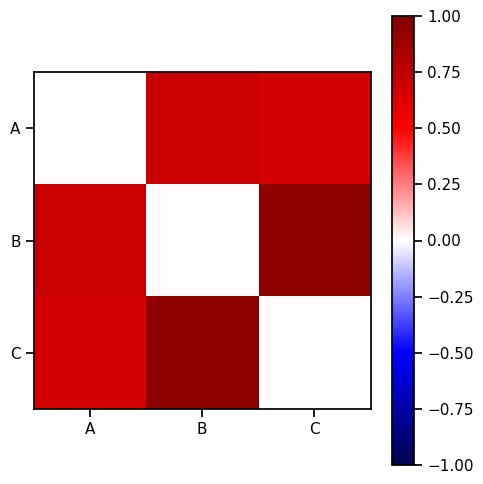

In [17]:
# plot the estimated correlation matrix (zero out the diagonal)

np.fill_diagonal(est_corr, 0)

fig = plt.figure(figsize=(5,5))
plt.imshow(est_corr, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Quantify how closely the estimated correlation matrix matches that found
from the data. To do this, vectorize the lower-triangular elements in the true
and estimated matrices and compute the Pearson correlation between the two vectors.

`np.corrcoef` and `np.tril_indices` may be useful here.

In [18]:
true_vec = corr[np.tril_indices(corr.shape[0], k=-1)].flatten()
est_vec = est_corr[np.tril_indices(est_corr.shape[0],-1)].flatten()
print(np.corrcoef(true_vec, est_vec)[0,1])

0.9998932418761982
